In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [1]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input,merge, Lambda,Reshape,add,Flatten, Dense,Concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D,Dropout,Conv2DTranspose,UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers 
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import generic_utils as keras_generic_utils

/Users/dk185175/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/dk185175/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from IPython.display import clear_output
from PIL import Image

In [3]:
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"
        path = glob('datasets/%s/%s/*' % (self.dataset_name, data_type))
#         print(path)

        batch_images = np.random.choice(path, size=batch_size)

        imgs_A = []
        imgs_B = []
        for img_path in batch_images:
            img = self.imread(img_path)

            h, w, _ = img.shape
            _w = int(w/2)
            img_A, img_B = img[:, :_w, :], img[:, _w:, :]

            img_A = scipy.misc.imresize(img_A, self.img_res)
            img_B = scipy.misc.imresize(img_B, self.img_res)

            # If training => do random flip
            if not is_testing and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)

        imgs_A = np.array(imgs_A)/127.5 - 1.
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))

        self.n_batches = int(len(path) / batch_size)

        for i in range(self.n_batches-1):
            batch = path[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img in batch:
                img = self.imread(img)
                h, w, _ = img.shape
                half_w = int(w/2)
                img_A = img[:, :half_w, :]
                img_B = img[:, half_w:, :]

                img_A = scipy.misc.imresize(img_A, self.img_res)
                img_B = scipy.misc.imresize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B


    def imread(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

In [4]:
import datetime

In [5]:
optimizer = RMSprop(lr=0.00005)

In [6]:
class WGAN():
    def __init__(self):
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
#         self.latent_dim = 100
           # Configure data loader
        self.dataset_name = 'facades'
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64


        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_discriminator()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
         # Input images and their conditioning images
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.critic.trainable = False
       
        
        # Discriminators determines validity of translated images / condition pairs
        valid = self.critic([fake_A, img_B])

        # The combined model  (stacked generator and critic)
        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=[self.wasserstein_loss,'mae'],
            optimizer=optimizer,
            loss_weights=[1, 100],
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1, sample_interval=50):
        
        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for _ in range(self.n_critic):
                for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
                    fake_A = self.generator.predict(imgs_B)  
                    d_loss_real = self.critic.train_on_batch([imgs_A, imgs_B], valid)
                    d_loss_fake = self.critic.train_on_batch([fake_A, imgs_B], fake)
                    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)                      
                    # Clip critic weights
                    for l in self.critic.layers:
                        weights = l.get_weights()
                        weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                        l.set_weights(weights)
                    print ("%d [D loss: %f]" % (epoch, 1 - d_loss[0]))
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
                print ("%d [G loss: %f]" % (epoch, 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                clear_output(wait=True)
                self.sample_images(epoch,batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 3, 3

        imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_testing=True)
        fake_A = self.generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
#         print(fake_A)

        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("wgan/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()

In [7]:
wgan = WGAN()

In [11]:
wgan.generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_5[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [12]:
wgan.critic.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256, 256, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 6208        concatenate_1[0][0]              
__________

/data2/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
wgan.train(epochs=100, batch_size=1, sample_interval=10)

In [68]:
wgan.generator.save_weights('wgan_generator.h5')

In [70]:
wgan.critic.save_weights('wgan_critic.h5')

In [71]:
wgan.combined.save_weights('wgan_combined.h5')

In [9]:
wgan.generator.load_weights('wgan_generator.h5')

In [10]:
wgan.critic.load_weights('wgan_critic.h5')

In [11]:
wgan.combined.load_weights('wgan_combined.h5')

/data2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/data2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/data2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


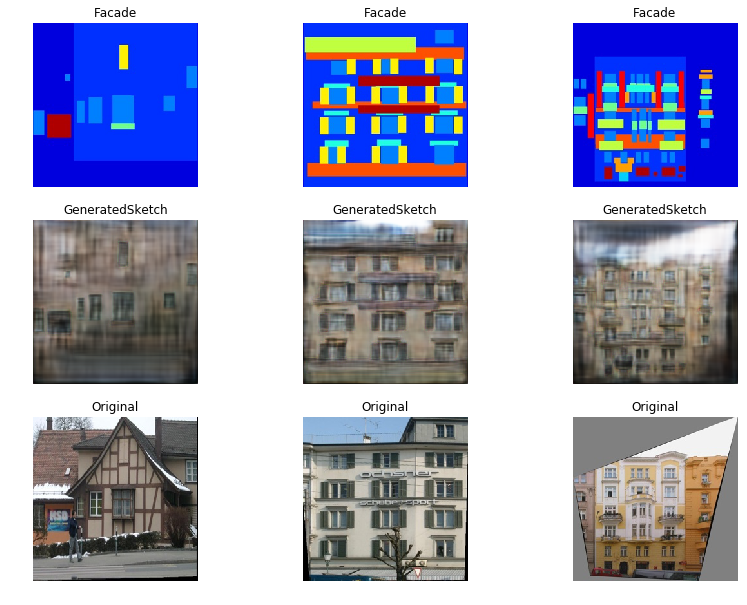

In [61]:
r, c = 3, 3

imgs_A, imgs_B = wgan.data_loader.load_data(batch_size=3, is_testing=True)
fake_A = wgan.generator.predict(imgs_B)

gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

titles = ['Facade', 'GeneratedSketch', 'Original']
a4_dims = (13.7, 10.27)
fig, axs = plt.subplots(r, c,figsize=a4_dims)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[i, j].set_title(titles[i])
        axs[i,j].axis('off')
        cnt += 1
plt.show()

In [12]:
wgan.critic.compile(loss=wgan.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

In [13]:
wgan.combined.compile(loss=[wgan.wasserstein_loss,'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

In [14]:
wgan.generator.compile(loss=['mae'],
            optimizer=optimizer,
            metrics=['accuracy'])

In [15]:
imgs_A, imgs_B = wgan.data_loader.load_data(batch_size=106, is_testing=True)

/Users/dk185175/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/dk185175/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/Users/dk185175/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [66]:
result = wgan.generator.evaluate(imgs_B,imgs_A)

106/106 [==============================] - 6s 56ms/step


In [67]:
print("%s: %.2f%%" % (wgan.generator.metrics_names[1], result[1]*100))

acc: 53.31%


In [ ]:
wgan.train(epochs=100, batch_size=1, sample_interval=5)

### Calculate Cosine Similarity

In [16]:
def cos_sim(a, b):
    """Takes 2 vectors a, b and returns the cosine similarity according 
    to the definition of the dot product
    """
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [18]:
pred_imgs=wgan.generator.predict(imgs_B)

In [19]:
final_cosine=[]
for i in range(imgs_A.shape[0]):
    temp=cos_sim(imgs_A[i].ravel(),pred_imgs[i].ravel())
    final_cosine.append(temp)

In [20]:
toatal_cos=0
for i in final_cosine:
    toatal_cos+=i
avg_cosine=toatal_cos/imgs_B.shape[0]

In [21]:
avg_cosine

0.44307615816551243

### Calculate L2 Distance

In [23]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

In [24]:
final_l2=[]
for i in range(imgs_A.shape[0]):
    temp=mse(imgs_A[i],pred_imgs[i])
    final_l2.append(temp)

In [26]:
total_l2=0
for i in final_l2:
    total_l2+=i
avg_l2=total_l2/imgs_B.shape[0]

In [27]:
avg_l2

0.6421150341301608